In [ ]:

# STEP 1: INSTALL
!pip install star-privateer lightkurve astropy numpy scipy matplotlib pandas tqdm pathos --break-system-packages
!pip install oktopus
!python -c "import star_privateer as sp; import lightkurve as lk; print('Packages installed successfully!')"


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# STEP 2: IMPORTS
import lightkurve as lk
import star_privateer as sp
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from scipy.signal import detrend
import pandas as pd
import os
import astropy.units as u

Cache cleared – downloading sectors [14, 15]
Found 2 data products across sectors
Stitched: 33,299 points, baseline 54.1 days (~91.6 cycles)


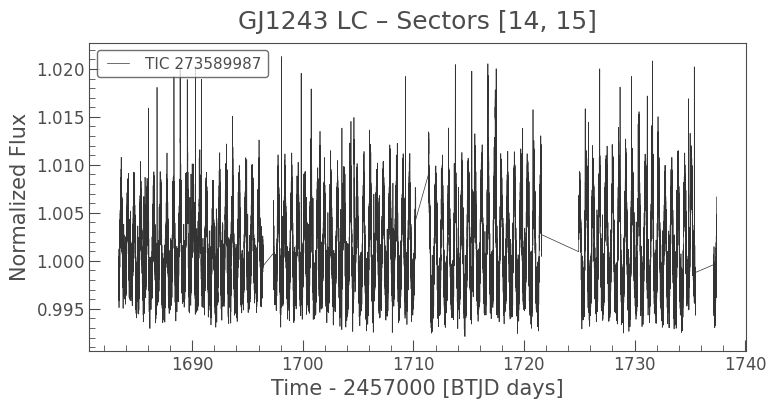

In [ ]:
# STEP 3: LOAD TESS DATA
tic_id = '273589987'
sectors = [14, 15]    # Confirmed sectors (Davenport et al. 2020)

# Clear cache
!rm -rf /root/.lightkurve/cache
print("Cache cleared – downloading sectors", sectors)


search = lk.search_lightcurve(f'TIC {tic_id}', sector=sectors, author='SPOC')
print(f"Found {len(search)} data products across sectors")

lcs = search.download_all()  # Downloads all SPOC LCs
if len(lcs) == 0:
    raise ValueError("No valid light curve data downloaded. Check sectors in MAST or TIC ID.")


lc = lcs.stitch()  # Combines sectors, fills gaps

# Clean (Your original)
lc = lc.remove_nans().remove_outliers(sigma=5).normalize()

t = lc.time.value
s = lc.flux.value

print(f"Stitched: {len(t):,} points, baseline {t[-1]-t[0]:.1f} days (~{(t[-1]-t[0])/0.59:.1f} cycles)")

# Plot LC
lc.plot(title=f'GJ1243 LC – Sectors {sectors}')
plt.savefig('gj1243_lc.png', dpi=300)
plt.show()


Lightkurve LS: 0.593 days (power=0.005)


<Figure size 800x400 with 0 Axes>

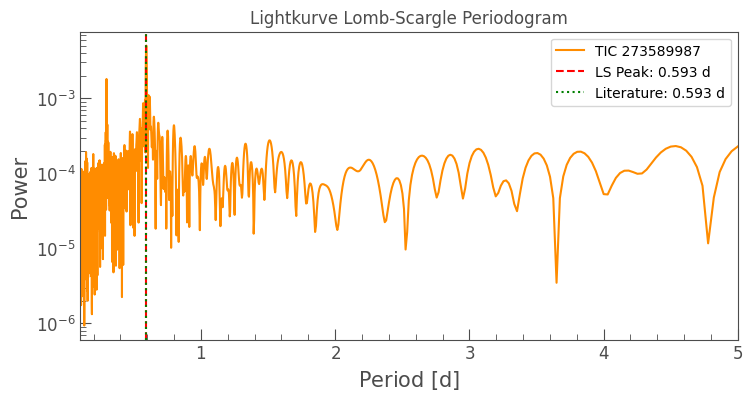

In [ ]:
# STEP 4: LIGHTKURVE LOMB-SCARGLE
pg = lc.to_periodogram(method='lombscargle', minimum_period=0.1*u.day, maximum_period=5*u.day, oversample_factor=10)
ls_period = pg.period_at_max_power.value
ls_power = pg.max_power.value
print(f"Lightkurve LS: {ls_period:.3f} days (power={ls_power:.3f})")

plt.figure(figsize=(8,4))
pg.plot(color='darkorange', lw=1.5)
plt.axvline(ls_period, color='red', ls='--', label=f'LS Peak: {ls_period:.3f} d')
plt.axvline(0.5926, color='green', ls=':', label='Literature: 0.593 d')
plt.xlim(0.1, 5); plt.yscale('log')
plt.title('Lightkurve Lomb-Scargle Periodogram')
plt.legend()
plt.savefig('gj1243_ls_periodogram.png', dpi=300)
plt.show()


In [ ]:
# STEP 5: PREPROCESSING

#  's' is a plain numpy array to prevent astropy MaskedNDArray TypeErrors later.
s = np.asarray(s)

# Manual iterative sigma clipping to avoid astropy.stats.sigma_clip 'TypeError'
s_for_clip = s.copy()
for _ in range(3):
    # Calculate mean and stddev only on non-NaN values for robustness
    s
    clean_s = s_for_clip[~np.isnan(s_for_clip)]
    if len(clean_s) == 0:
        break

    mean_val = np.mean(clean_s)
    std_val = np.std(clean_s)

    # Define clipping bounds (sigma=4.0)
    lower_bound = mean_val - 4.0 * std_val
    upper_bound = mean_val + 4.0 * std_val

    # Mask values outside these bounds by setting them to NaN
    outliers_mask = (s_for_clip < lower_bound) | (s_for_clip > upper_bound)
    s_for_clip[outliers_mask] = np.nan

s = s_for_clip # Assign the clipped result back to 's'

s = np.nan_to_num(s, nan=np.nanmedian(s))
s = detrend(s, type='linear') # Detrend the data
s = (s - np.mean(s)) / np.std(s) # Normalize the data

# Rebin to 4h (Your original)
bin_h = 4
t, s = sp.rebin(t, bin_h), sp.rebin(s, bin_h)
dt = bin_h * 3600
print(f"Preprocessed & Rebinned: {len(t)} points")

Preprocessed & Rebinned: 8324 points


In [ ]:
# STEP 6: STAR PRIVETEER / ROOSTER PIPELINE
output_dir = 'gj1243_analysis'
os.makedirs(output_dir, exist_ok=True)

(p_wps, p_acf, gwps, wps, acf, cs, coi, features, feature_names, _) = sp.analysis_pipeline(
    t, s,
    figsize=(10, 14), plot=True,
    xlim=(0.1, 5),  # Short for M-dwarf
    normscale='log', ylogscale=True,
    add_periodogram=True,
    wavelet_analysis=True
)

# Save plot
plt.savefig(f'{output_dir}/rooster_gj1243.png', dpi=300, bbox_inches='tight')
plt.close()

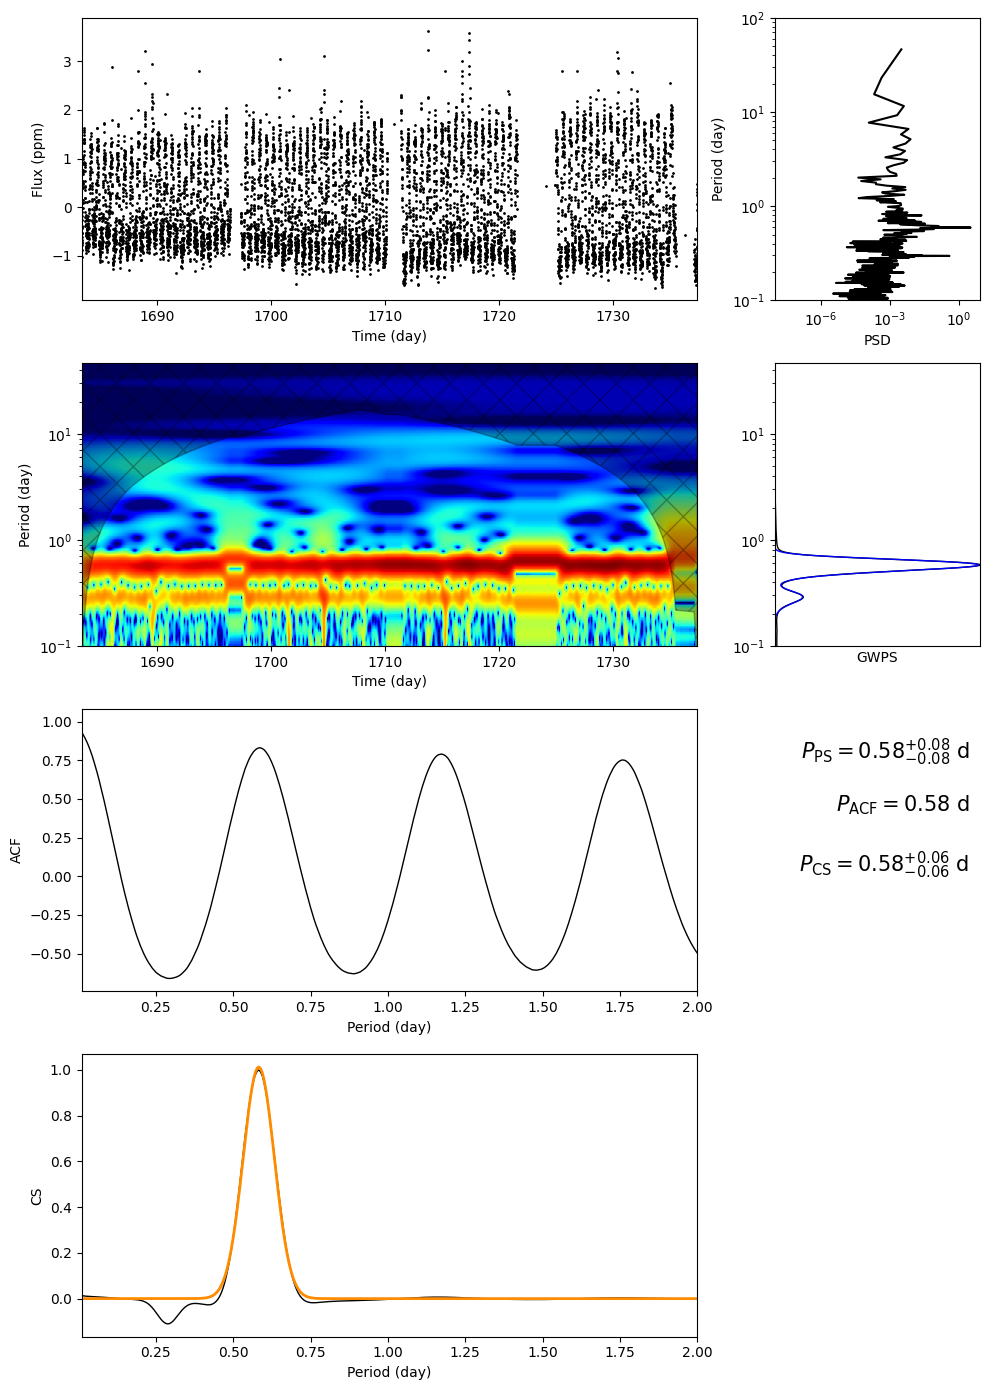

In [ ]:
output_dir = 'gj1243_analysis'
os.makedirs(output_dir, exist_ok=True)

(p_wps, p_acf, gwps, wps, acf, cs, coi, features, feature_names, _) = sp.analysis_pipeline(
    t, s,
    figsize=(10, 14), plot=True,
    xlim=(0.01, 2),  # Widened range for M-dwarf
    normscale='log', ylogscale=True,
    add_periodogram=True,
    wavelet_analysis=True
)

# Save plot
plt.savefig(f'{output_dir}/rooster_gj1243.png', dpi=300, bbox_inches='tight')